# Machine Learning Models Implementation

This notebook implements several ML models based on the EDA and PCA results. The top 14 features identified after PCA are used for modeling. The workflow includes:

- Data loading and preprocessing (scaling, one-hot encoding)
- Train/validation/test split (80/10/10)
- Model training and hyperparameter tuning using Optuna
- Models: Logistic Regression (Ridge & Lasso), Naive Bayes, Random Forest, SVM, Decision Tree

**Top 14 Features:**
1. RiskScore
2. MonthlyCharges
3. AvgChargesPerMonth
4. ContractRisk
5. Contract
6. TotalServices
7. TotalCharges
8. EstimatedCLV
9. HasFamily
10. tenure
11. Partner
12. HighValueCustomer
13. PaymentRisk
14. Dependents

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set constant seed for reproducibility
SEED = 42
np.random.seed(SEED)
# Remove optuna.seed(SEED) as it does not exist
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('optuna').setLevel(logging.ERROR)
logging.getLogger('xgboost').setLevel(logging.ERROR)
logging.getLogger('lightgbm').setLevel(logging.ERROR)

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pip install optuna
%pip install imblearn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
import numpy as np
import pandas as pd

# ============================================================
# 1. Global deterministic setup (must be at the very top)
# ============================================================

SEED = 42

# Python & NumPy randomness
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Force single-threaded math libs for determinism
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# ============================================================
# 2. Imports (after env vars)
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline

# (Optional) example model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ============================================================
# 3. Load data and define features
# ============================================================

features = [
    'RiskScore', 'MonthlyCharges', 'AvgChargesPerMonth', 'ContractRisk', 'Contract',
    'TotalServices', 'TotalCharges', 'EstimatedCLV', 'HasFamily', 'tenure',
    'Partner', 'HighValueCustomer', 'PaymentRisk', 'Dependents'
]

df = pd.read_csv('final_telco_engineered.csv')

X = df[features]
# Update if your target column has a different name
y = df['Churn']

categorical_cols = ['Contract', 'HasFamily', 'Partner', 'HighValueCustomer', 'Dependents']
numerical_cols = [col for col in features if col not in categorical_cols]

# ============================================================
# 4. Preprocessing pipeline (dense, deterministic)
# ============================================================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        # For newer sklearn: sparse_output=False
        # For older: use sparse=False (you may get a warning on one of them, but it will still work)
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

# If you get an error about sparse_output, switch to:
# ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), categorical_cols)

# ============================================================
# 5. Train / val / test split (80 / 10 / 10)
# ============================================================

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1111,   # 0.1111 * 0.90 ≈ 0.10
    random_state=SEED,
    stratify=y_temp
)

# ============================================================
# 6. Fit preprocessor ONLY on training, transform all splits
# ============================================================

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

# Ensure dense float64 (for stable KNN in SMOTE/ENN)
X_train_proc = np.asarray(X_train_proc, dtype=np.float64)
X_val_proc   = np.asarray(X_val_proc,   dtype=np.float64)
X_test_proc  = np.asarray(X_test_proc,  dtype=np.float64)

# ============================================================
# 7. SMOTE + ENN on TRAINING DATA ONLY (deterministic)
# ============================================================

print("Before SMOTE+ENN:")
print(y_train.value_counts())
print("Class distribution:")
print(y_train.value_counts(normalize=True))

# Explicit SMOTE and ENN with fixed random_state
smote = SMOTE(
    random_state=SEED,
    sampling_strategy='auto',  # oversample minority up to majority
    k_neighbors=5
)

enn = EditedNearestNeighbours(
    n_neighbors=3,   # standard ENN
    kind_sel='all'   # deterministic behavior
)

smote_enn = ImbPipeline(steps=[
    ('smote', smote),
    ('enn', enn)
])

X_train_resampled, y_train_resampled = smote_enn.fit_resample(
    X_train_proc,
    y_train
)

print("\nAfter SMOTE+ENN:")
print(y_train_resampled.value_counts())
print("Class distribution:")
print(y_train_resampled.value_counts(normalize=True))

# Use these for training models
X_train_proc = X_train_resampled
y_train      = y_train_resampled

Before SMOTE+ENN:
Churn
No     4138
Yes    1495
Name: count, dtype: int64
Class distribution:
Churn
No     0.7346
Yes    0.2654
Name: proportion, dtype: float64

After SMOTE+ENN:
Churn
No     4138
Yes    2670
Name: count, dtype: int64
Class distribution:
Churn
No     0.607814
Yes    0.392186
Name: proportion, dtype: float64


## Hyperparameter Tuning and Model Training

The following cells use Optuna for hyperparameter optimization for each model. The best model from validation is then evaluated on the test set.

In [4]:
# Metrics helper: accuracy, precision, recall, specificity, F1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_metrics(y_true, y_pred, pos_label):
    labels = np.unique(y_true)
    if pos_label not in labels:
        raise ValueError("pos_label not found in y_true labels.")
    # Determine negative label (binary case expected)
    neg_candidates = [l for l in labels if l != pos_label]
    specificity = float('nan')
    if len(neg_candidates) == 1:
        neg_label = neg_candidates[0]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[neg_label, pos_label]).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | Specificity: {specificity:.4f} | F1: {f1:.4f}")

Trial 0: penalty=l2, C=0.8471801418819978, f1=0.5949
Trial 1: penalty=l1, C=0.004207053950287938, f1=0.6139
Trial 2: penalty=l2, C=0.2537815508265665, f1=0.5928
Trial 3: penalty=l1, C=7.579479953348009, f1=0.5861
Trial 4: penalty=l1, C=0.005337032762603957, f1=0.6119
Trial 5: penalty=l2, C=0.12561043700013558, f1=0.5943
Trial 6: penalty=l1, C=0.2801635158716261, f1=0.5913
Trial 7: penalty=l2, C=0.029204338471814112, f1=0.5907
Trial 8: penalty=l2, C=0.006290644294586149, f1=0.5916
Trial 9: penalty=l2, C=0.0015339162591163618, f1=0.5879
Trial 10: penalty=l1, C=0.0010567900894501681, f1=0.5736
Trial 11: penalty=l1, C=0.014038256914381365, f1=0.5995
Trial 12: penalty=l1, C=0.005001461176511256, f1=0.6074
Trial 13: penalty=l1, C=0.03713740624438136, f1=0.5918
Trial 14: penalty=l1, C=0.0031784244157476295, f1=0.6199
Trial 15: penalty=l1, C=0.003244603018219866, f1=0.6184
Trial 16: penalty=l1, C=0.024491813069245447, f1=0.5882
Trial 17: penalty=l1, C=0.0018178456157878842, f1=0.6130
Trial 18:

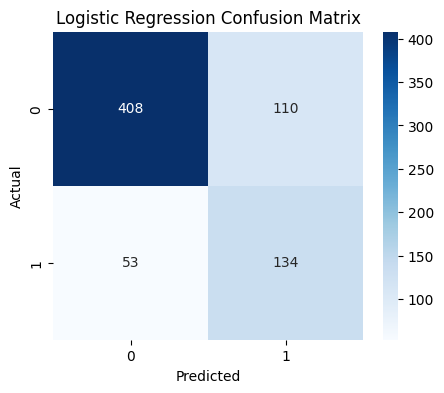

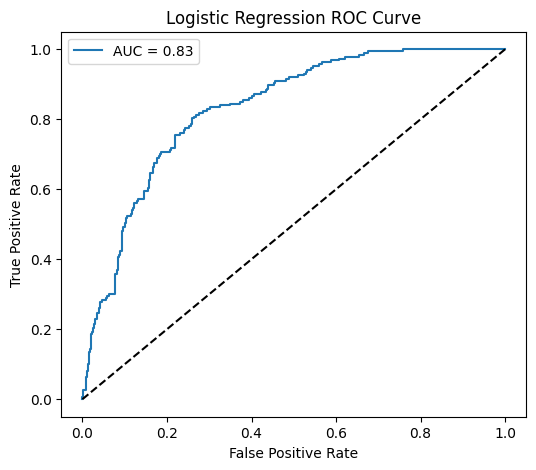

In [5]:
# Logistic Regression (Ridge & Lasso) with Optuna and single validation split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def objective_logreg(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 1e-3, 10.0, log=True)
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    clf = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=1000, random_state=SEED)
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
    print(f'Trial {trial.number}: penalty={penalty}, C={C}, f1={score:.4f}')
    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_logreg = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_logreg.optimize(objective_logreg, n_trials=50)

print('\n=== Logistic Regression Best Hyperparameters ===')
print(f'Best trial: {study_logreg.best_trial.number}')
print(f'Best F1 score: {study_logreg.best_value:.4f}')
print(f'Best params: {study_logreg.best_params}')

best_params_logreg = study_logreg.best_params
best_logreg = LogisticRegression(**best_params_logreg, solver='liblinear' if best_params_logreg['penalty']=='l1' else 'lbfgs', max_iter=1000, random_state=SEED)
best_logreg.fit(X_train_proc, y_train)
y_test_pred_logreg = best_logreg.predict(X_test_proc)
y_test_proba_logreg = best_logreg.predict_proba(X_test_proc)[:, 1]

print('Logistic Regression Test Metrics:')
print_metrics(y_test, y_test_pred_logreg, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_logreg)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_logreg, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_logreg)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.show()

In [6]:
# Logistic Regression: Top 5 Features based on coefficients
# Get feature names after preprocessing
feature_names = []
# Numerical features (scaled)
feature_names.extend(numerical_cols)
# Categorical features (one-hot encoded, first category dropped)
for col in categorical_cols:
    unique_vals = df[col].unique()
    # OneHotEncoder drops first category, so we get n-1 features
    for val in sorted(unique_vals)[1:]:
        feature_names.append(f"{col}_{val}")

# Get coefficients
coefficients = best_logreg.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\n=== Logistic Regression: Top 5 Most Important Features ===")
print(feature_importance.head(5).to_string(index=False))
print("\nNote: Features with larger absolute coefficients have stronger influence on predictions.")


=== Logistic Regression: Top 5 Most Important Features ===
           Feature  Coefficient  Abs_Coefficient
         RiskScore     0.729716         0.729716
    MonthlyCharges     0.412280         0.412280
      ContractRisk     0.128536         0.128536
            tenure    -0.074029         0.074029
AvgChargesPerMonth     0.000000         0.000000

Note: Features with larger absolute coefficients have stronger influence on predictions.


Trial 0: var_smoothing=3.148911647956852e-10, f1=0.6047
Trial 1: var_smoothing=6.351221010640693e-08, f1=0.6047
Trial 2: var_smoothing=8.47180141881997e-09, f1=0.6047
Trial 3: var_smoothing=2.481040974867806e-09, f1=0.6047
Trial 4: var_smoothing=4.2079886696066266e-11, f1=0.6047
Trial 5: var_smoothing=4.2070539502879275e-11, f1=0.6047
Trial 6: var_smoothing=1.707396743152808e-11, f1=0.6047
Trial 7: var_smoothing=2.9154431891537547e-08, f1=0.6047
Trial 8: var_smoothing=2.5378155082656586e-09, f1=0.6047
Trial 9: var_smoothing=6.796578090758142e-09, f1=0.6047
Trial 10: var_smoothing=3.147070849889824e-10, f1=0.6047
Trial 11: var_smoothing=3.6313970346434915e-10, f1=0.6047
Trial 12: var_smoothing=7.553503645583179e-08, f1=0.6047
Trial 13: var_smoothing=2.4400771927662207e-10, f1=0.6047
Trial 14: var_smoothing=9.714866589957516e-10, f1=0.6047
Trial 15: var_smoothing=2.7531913049290154e-08, f1=0.6047
Trial 16: var_smoothing=1.0514141925502058e-10, f1=0.6047
Trial 17: var_smoothing=1.12720480

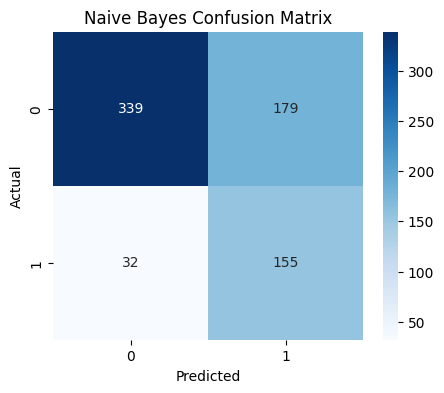

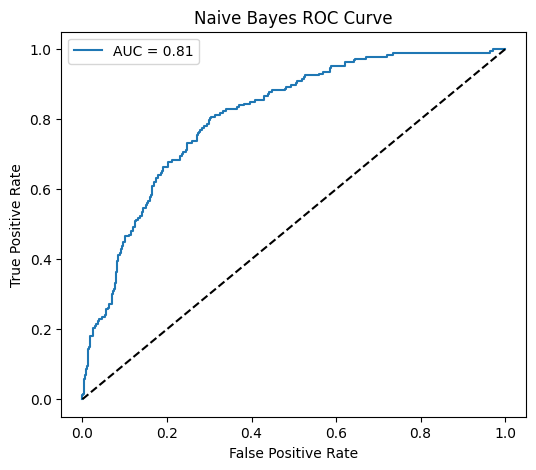

In [7]:
# Naive Bayes with Optuna (GaussianNB) and single validation split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def objective_nb(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-11, 1e-7, log=True)
    clf = GaussianNB(var_smoothing=var_smoothing)
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
    print(f'Trial {trial.number}: var_smoothing={var_smoothing}, f1={score:.4f}')
    return score

study_nb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_nb.optimize(objective_nb, n_trials=50)

print('\n=== Naive Bayes Best Hyperparameters ===')
print(f'Best trial: {study_nb.best_trial.number}')
print(f'Best F1 score: {study_nb.best_value:.4f}')
print(f'Best params: {study_nb.best_params}')

best_params_nb = study_nb.best_params
best_nb = GaussianNB(**best_params_nb)
best_nb.fit(X_train_proc, y_train)
y_test_pred_nb = best_nb.predict(X_test_proc)
y_test_proba_nb = best_nb.predict_proba(X_test_proc)[:, 1]

print('Naive Bayes Test Metrics:')
print_metrics(y_test, y_test_pred_nb, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_nb, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_nb)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.legend()
plt.show()

Trial 0: n_estimators=144, max_depth=20, min_samples_split=8, min_samples_leaf=6, f1=0.5739
Trial 1: n_estimators=89, max_depth=4, min_samples_split=2, min_samples_leaf=9, f1=0.6098
Trial 2: n_estimators=200, max_depth=15, min_samples_split=2, min_samples_leaf=10, f1=0.5905
Trial 3: n_estimators=258, max_depth=6, min_samples_split=3, min_samples_leaf=2, f1=0.6194
Trial 4: n_estimators=126, max_depth=11, min_samples_split=5, min_samples_leaf=3, f1=0.5819
Trial 5: n_estimators=203, max_depth=4, min_samples_split=4, min_samples_leaf=4, f1=0.6218
Trial 6: n_estimators=164, max_depth=16, min_samples_split=3, min_samples_leaf=6, f1=0.5756
Trial 7: n_estimators=198, max_depth=2, min_samples_split=7, min_samples_leaf=2, f1=0.5938
Trial 8: n_estimators=66, max_depth=20, min_samples_split=10, min_samples_leaf=9, f1=0.5779
Trial 9: n_estimators=126, max_depth=3, min_samples_split=8, min_samples_leaf=5, f1=0.6082
Trial 10: n_estimators=289, max_depth=8, min_samples_split=5, min_samples_leaf=4, f1=

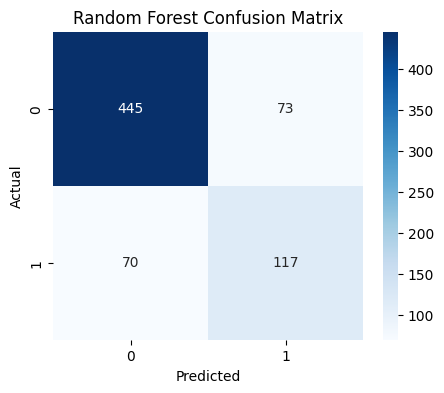

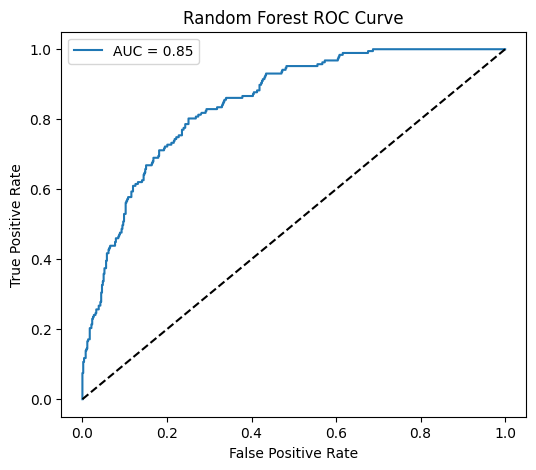

In [8]:
# Random Forest with Optuna and single validation split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED
    )
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
    print(f'Trial {trial.number}: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, f1={score:.4f}')
    return score

study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_rf.optimize(objective_rf, n_trials=50)

print('\n=== Random Forest Best Hyperparameters ===')
print(f'Best trial: {study_rf.best_trial.number}')
print(f'Best F1 score: {study_rf.best_value:.4f}')
print(f'Best params: {study_rf.best_params}')

best_params_rf = study_rf.best_params
best_rf = RandomForestClassifier(**best_params_rf, random_state=SEED)
best_rf.fit(X_train_proc, y_train)
y_test_pred_rf = best_rf.predict(X_test_proc)
y_test_proba_rf = best_rf.predict_proba(X_test_proc)[:, 1]

print('Random Forest Test Metrics:')
print_metrics(y_test, y_test_pred_rf, pos_label='Yes')

print('Random Forest Test Accuracy:', accuracy_score(y_test, y_test_pred_rf))
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_rf, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()


=== Random Forest: Top 5 Most Important Features ===
           Feature  Importance
         RiskScore    0.194313
      ContractRisk    0.171283
            tenure    0.113189
    MonthlyCharges    0.108674
AvgChargesPerMonth    0.095566


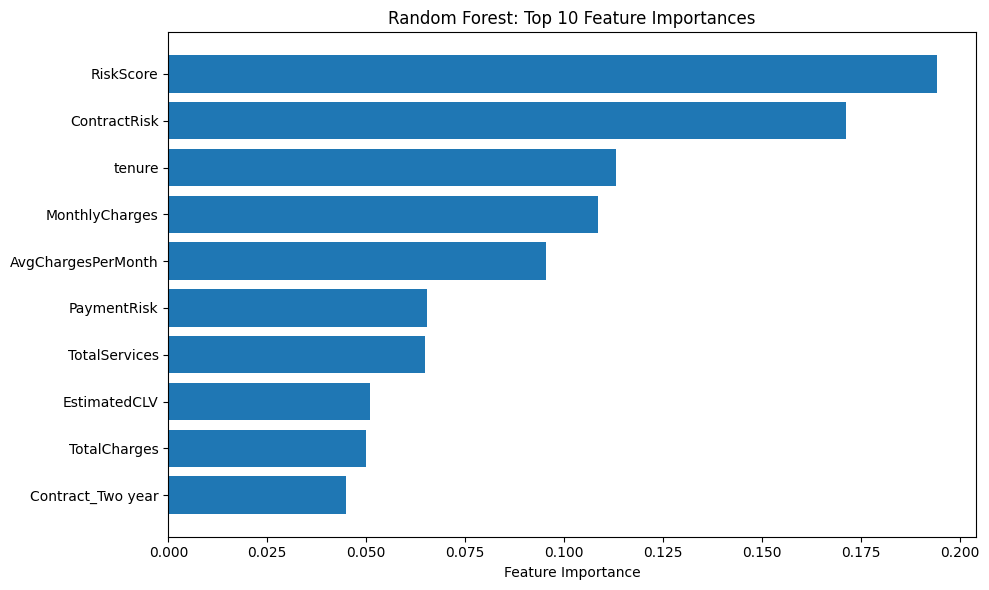


Note: Feature importance is calculated as the mean decrease in impurity (Gini importance).


In [9]:
# Random Forest: Top 5 Features based on importance
rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Random Forest: Top 5 Most Important Features ===")
print(rf_feature_importance.head(5).to_string(index=False))

# Visualize feature importances
plt.figure(figsize=(10, 6))
top_10_features = rf_feature_importance.head(10)
plt.barh(range(len(top_10_features)), top_10_features['Importance'])
plt.yticks(range(len(top_10_features)), top_10_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest: Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nNote: Feature importance is calculated as the mean decrease in impurity (Gini importance).")

Trial 0: C=0.0746, kernel=linear, gamma=0.0003, f1=0.6025
Trial 1: C=0.0060, kernel=rbf, gamma=0.0133, f1=0.6189
Trial 2: C=0.0013, kernel=linear, gamma=0.0004, f1=0.6051
Trial 3: C=0.0083, kernel=rbf, gamma=0.0007, f1=0.0000
Trial 4: C=1.1462, kernel=poly, gamma=0.0023, f1=0.0000
Trial 5: C=8.4310, kernel=poly, gamma=0.0001, f1=0.0000
Trial 6: C=1.0907, kernel=poly, gamma=0.0789, f1=0.5963
Trial 7: C=11.0151, kernel=poly, gamma=0.0021, f1=0.0000
Trial 8: C=0.0041, kernel=poly, gamma=0.0006, f1=0.0000
Trial 9: C=2.0541, kernel=poly, gamma=0.0004, f1=0.0000
Trial 10: C=0.0611, kernel=rbf, gamma=0.0250, f1=0.5949
Trial 11: C=0.0011, kernel=linear, gamma=0.0107, f1=0.6071
Trial 12: C=0.0189, kernel=rbf, gamma=0.0171, f1=0.6107
Trial 13: C=0.0260, kernel=rbf, gamma=0.0108, f1=0.6041
Trial 14: C=0.1850, kernel=rbf, gamma=0.0324, f1=0.5855
Trial 15: C=0.0085, kernel=rbf, gamma=0.0074, f1=0.6006
Trial 16: C=0.0216, kernel=rbf, gamma=0.0048, f1=0.6188
Trial 17: C=0.2990, kernel=rbf, gamma=0.00

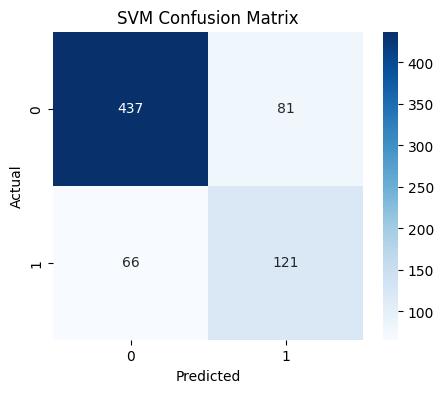

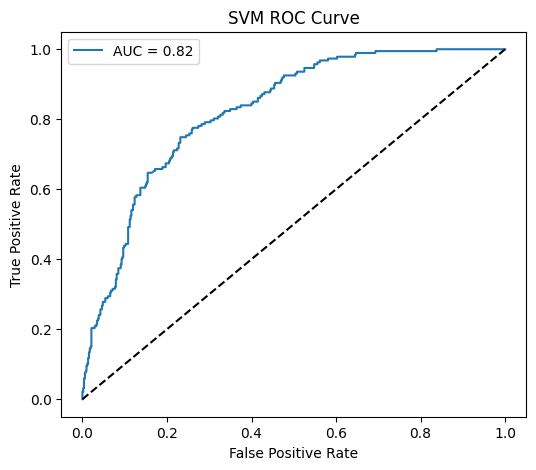

In [10]:
# SVM with Optuna and single validation split, with timeout for each trial
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import threading
import warnings
warnings.filterwarnings('ignore')

# Timeout wrapper for objective function
class TrialTimeout(Exception):
    pass

def run_with_timeout(func, args=(), kwargs=None, timeout=60):
    result = {}
    def target():
        try:
            result['value'] = func(*args, **(kwargs or {}))
        except Exception as e:
            result['error'] = e
    thread = threading.Thread(target=target)
    thread.start()
    thread.join(timeout)
    if thread.is_alive():
        raise TrialTimeout('Trial exceeded timeout')
    if 'error' in result:
        raise result['error']
    return result.get('value')

def objective_svm(trial):
    def inner_objective():
        C = trial.suggest_float('C', 1e-3, 1e2, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        gamma = trial.suggest_float('gamma', 1e-4, 1e-1, log=True)
        clf = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, random_state=SEED)
        clf.fit(X_train_proc, y_train)
        y_pred = clf.predict(X_val_proc)
        score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
        print(f'Trial {trial.number}: C={C:.4f}, kernel={kernel}, gamma={gamma:.4f}, f1={score:.4f}')
        return score
    try:
        return run_with_timeout(inner_objective, timeout=30)  # 30 seconds per trial
    except TrialTimeout:
        print(f'Trial {trial.number} timed out.')
        return 0.0  # Return poor score if timeout

study_svm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_svm.optimize(objective_svm, n_trials=50)

print('\n=== SVM Best Hyperparameters ===')
print(f'Best trial: {study_svm.best_trial.number}')
print(f'Best F1 score: {study_svm.best_value:.4f}')
print(f'Best params: {study_svm.best_params}')

best_params_svm = study_svm.best_params
best_svm = SVC(**best_params_svm, probability=True, random_state=SEED)
best_svm.fit(X_train_proc, y_train)
y_test_pred_svm = best_svm.predict(X_test_proc)
y_test_proba_svm = best_svm.predict_proba(X_test_proc)[:, 1]

print('SVM Test Metrics:')
print_metrics(y_test, y_test_pred_svm, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_svm, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_svm)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend()
plt.show()

Trial 0: max_depth=9, min_samples_split=10, min_samples_leaf=8, f1=0.5598
Trial 1: max_depth=13, min_samples_split=3, min_samples_leaf=2, f1=0.4910
Trial 2: max_depth=3, min_samples_split=9, min_samples_leaf=7, f1=0.6170
Trial 3: max_depth=15, min_samples_split=2, min_samples_leaf=10, f1=0.5030
Trial 4: max_depth=17, min_samples_split=3, min_samples_leaf=2, f1=0.4554
Trial 5: max_depth=5, min_samples_split=4, min_samples_leaf=6, f1=0.5932
Trial 6: max_depth=10, min_samples_split=4, min_samples_leaf=7, f1=0.5225
Trial 7: max_depth=4, min_samples_split=4, min_samples_leaf=4, f1=0.5938
Trial 8: max_depth=10, min_samples_split=9, min_samples_leaf=2, f1=0.5217
Trial 9: max_depth=11, min_samples_split=7, min_samples_leaf=1, f1=0.5148
Trial 10: max_depth=2, min_samples_split=7, min_samples_leaf=10, f1=0.5553
Trial 11: max_depth=5, min_samples_split=6, min_samples_leaf=4, f1=0.5932
Trial 12: max_depth=2, min_samples_split=6, min_samples_leaf=4, f1=0.5553
Trial 13: max_depth=6, min_samples_spli

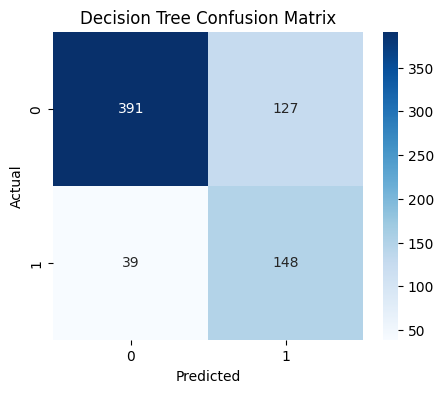

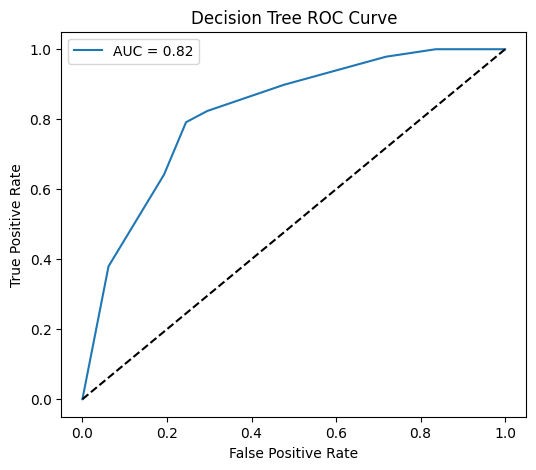

In [11]:
# Decision Tree with Optuna and single validation split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED
    )
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
    print(f'Trial {trial.number}: max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, f1={score:.4f}')
    return score

study_dt = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_dt.optimize(objective_dt, n_trials=50)

print('\n=== Decision Tree Best Hyperparameters ===')
print(f'Best trial: {study_dt.best_trial.number}')
print(f'Best F1 score: {study_dt.best_value:.4f}')
print(f'Best params: {study_dt.best_params}')

best_params_dt = study_dt.best_params
best_dt = DecisionTreeClassifier(**best_params_dt, random_state=SEED)
best_dt.fit(X_train_proc, y_train)
y_test_pred_dt = best_dt.predict(X_test_proc)
y_test_proba_dt = best_dt.predict_proba(X_test_proc)[:, 1]

print('Decision Tree Test Metrics:')
print_metrics(y_test, y_test_pred_dt, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_dt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_dt, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_dt)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend()
plt.show()


=== Decision Tree: Top 5 Most Important Features ===
          Feature  Importance
     ContractRisk    0.659777
   MonthlyCharges    0.179179
           tenure    0.147799
        RiskScore    0.013143
Contract_One year    0.000102


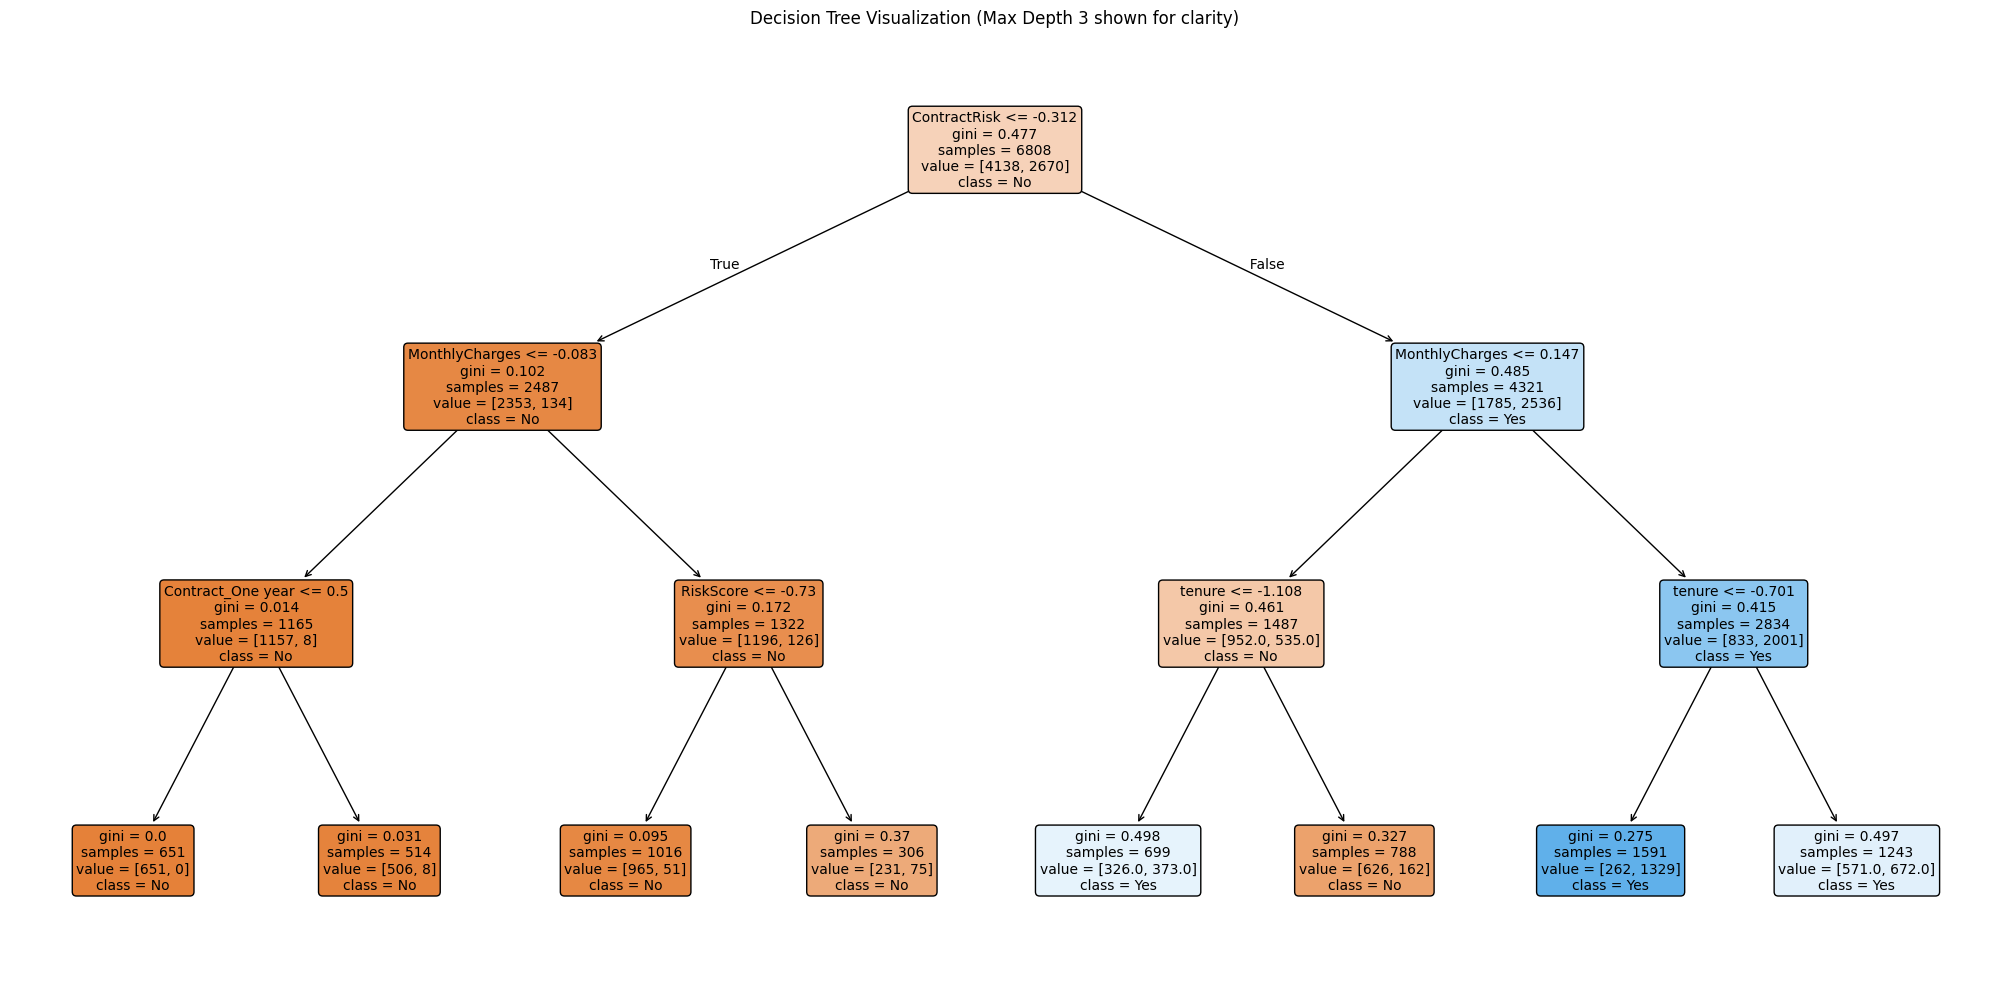


Note: The tree visualization shows the decision path. Each node shows:
  - The decision rule (feature threshold)
  - Gini impurity
  - Number of samples
  - Class distribution [No, Yes]
  - Predicted class (color coded)


In [12]:
# Decision Tree: Top 5 Features and Decision Path Visualization
from sklearn.tree import plot_tree

# Get feature importances
dt_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Decision Tree: Top 5 Most Important Features ===")
print(dt_feature_importance.head(5).to_string(index=False))

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt, 
          feature_names=feature_names,
          class_names=['No', 'Yes'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Limit depth for readability
plt.title('Decision Tree Visualization (Max Depth 3 shown for clarity)')
plt.tight_layout()
plt.show()

print("\nNote: The tree visualization shows the decision path. Each node shows:")
print("  - The decision rule (feature threshold)")
print("  - Gini impurity")
print("  - Number of samples")
print("  - Class distribution [No, Yes]")
print("  - Predicted class (color coded)")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Trial 0: n_estimators=144, max_depth=10, learning_rate=0.222, f1=0.5112
Trial 1: n_estimators=89, max_depth=2, learning_rate=0.261, f1=0.6137
Trial 2: n_estimators=55, max_depth=10, learning_rate=0.251, f1=0.5155
Trial 3: n_estimators=96, max_depth=4, learning_rate=0.162, f1=0.5829
Trial 4: n_estimators=203, max_depth=3, learning_rate=0.095, f1=0.5922
Trial 5: n_estimators=247, max_depth=3, learning_rate=0.159, f1=0.5731
Trial 6: n_estimators=202, max_depth=3, learning_rate=0.029, f1=0.6373
Trial 7: n_estimators=252, max_depth=4, learning_rate=0.038, f1=0.6154
Trial 8: n_estimators=80, max_depth=6, learning_rate=0.020, f1=0.6137
Trial 9: n_estimators=216, max_depth=4, learning_rate=0.161, f1=0.5697
Trial 10: n_estimators=289, max_depth=7, learning_rate=0.083, f1=0.5237
Trial 11: n_estimators=271, max_depth=6, lear

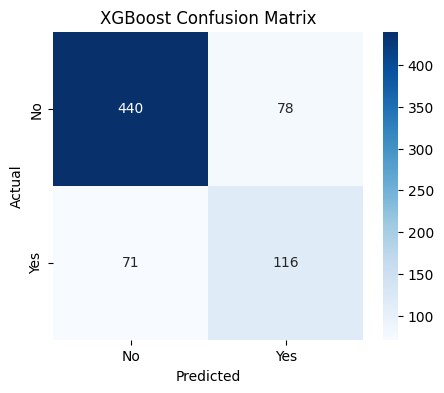

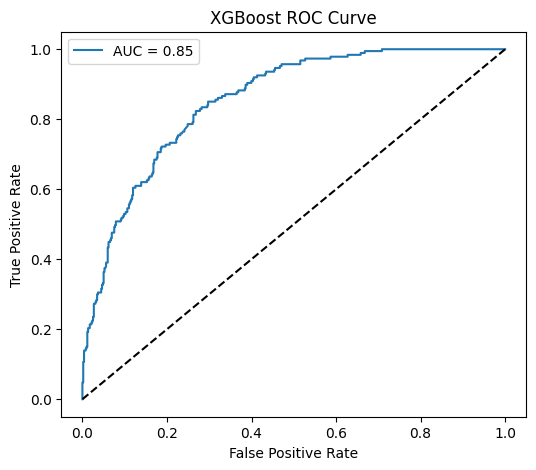

In [13]:
# XGBoost, LightGBM, and KNN with Optuna, validation split, and plots
# Install required packages if not already installed
%pip install xgboost lightgbm

# Encode target for XGBoost and LightGBM
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Compute encoded label for 'Yes' to use as pos_label in F1
yes_label = le.transform(['Yes'])[0]

# XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    clf.fit(X_train_proc, y_train_enc)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val_enc, y_pred, pos_label=yes_label, zero_division=0)
    print(f'Trial {trial.number}: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate:.3f}, f1={score:.4f}')
    return score

study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_xgb.optimize(objective_xgb, n_trials=50)

print('\n=== XGBoost Best Hyperparameters ===')
print(f'Best trial: {study_xgb.best_trial.number}')
print(f'Best F1 score: {study_xgb.best_value:.4f}')
print(f'Best params: {study_xgb.best_params}')

best_params_xgb = study_xgb.best_params
best_xgb = XGBClassifier(**best_params_xgb, random_state=SEED, use_label_encoder=False, eval_metric='logloss')
best_xgb.fit(X_train_proc, y_train_enc)
y_test_pred_xgb = best_xgb.predict(X_test_proc)
y_test_proba_xgb = best_xgb.predict_proba(X_test_proc)[:, 1]

print('XGBoost Test Metrics:')
yes_label = le.transform(['Yes'])[0]
print_metrics(y_test_enc, y_test_pred_xgb, pos_label=yes_label)

cm = confusion_matrix(y_test_enc, y_test_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test_enc, y_test_proba_xgb, pos_label=yes_label)
auc = roc_auc_score(y_test_enc, y_test_proba_xgb)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend()
plt.show()

[LightGBM] [Info] Number of positive: 2670, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 6808, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.392186 -> initscore=-0.438134
[LightGBM] [Info] Start training from score -0.438134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

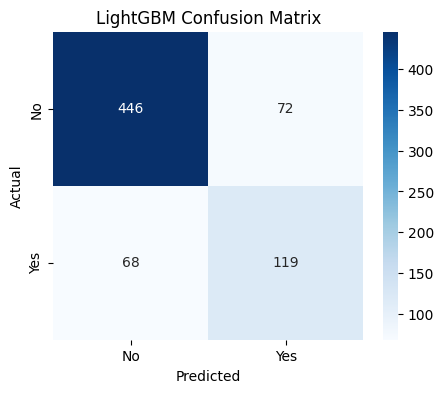

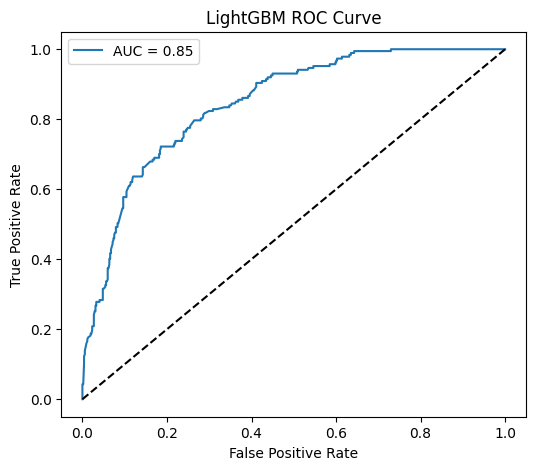

In [14]:
# LightGBM (with encoded labels)
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Use the same label encoder as XGBoost cell (already defined above)
# y_train_enc, y_val_enc, y_test_enc already exist

def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 10, 100)
    clf = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        random_state=SEED
    )
    clf.fit(X_train_proc, y_train_enc)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val_enc, y_pred, pos_label=yes_label, zero_division=0)
    print(f'Trial {trial.number}: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate:.3f}, num_leaves={num_leaves}, f1={score:.4f}')
    return score

study_lgbm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_lgbm.optimize(objective_lgbm, n_trials=50)

print('\n=== LightGBM Best Hyperparameters ===')
print(f'Best trial: {study_lgbm.best_trial.number}')
print(f'Best F1 score: {study_lgbm.best_value:.4f}')
print(f'Best params: {study_lgbm.best_params}')

best_params_lgbm = study_lgbm.best_params
best_lgbm = LGBMClassifier(**best_params_lgbm, random_state=SEED)
best_lgbm.fit(X_train_proc, y_train_enc)
y_test_pred_lgbm = best_lgbm.predict(X_test_proc)
y_test_proba_lgbm = best_lgbm.predict_proba(X_test_proc)[:, 1]

print('LightGBM Test Metrics:')
yes_label = le.transform(['Yes'])[0]
print_metrics(y_test_enc, y_test_pred_lgbm, pos_label=yes_label)

cm = confusion_matrix(y_test_enc, y_test_pred_lgbm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test_enc, y_test_proba_lgbm, pos_label=yes_label)
auc = roc_auc_score(y_test_enc, y_test_proba_lgbm)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend()
plt.show()

Trial 0: n_neighbors=13, weights=uniform, p=2, f1=0.5969
Trial 1: n_neighbors=7, weights=uniform, p=2, f1=0.5625
Trial 2: n_neighbors=19, weights=uniform, p=2, f1=0.5980
Trial 3: n_neighbors=26, weights=uniform, p=1, f1=0.5788
Trial 4: n_neighbors=11, weights=uniform, p=1, f1=0.5714
Trial 5: n_neighbors=20, weights=distance, p=1, f1=0.5668
Trial 6: n_neighbors=15, weights=uniform, p=2, f1=0.5906
Trial 7: n_neighbors=19, weights=distance, p=1, f1=0.5722
Trial 8: n_neighbors=4, weights=distance, p=2, f1=0.5115
Trial 9: n_neighbors=11, weights=distance, p=1, f1=0.5515
Trial 10: n_neighbors=29, weights=uniform, p=2, f1=0.5955
Trial 11: n_neighbors=23, weights=uniform, p=2, f1=0.6035
Trial 12: n_neighbors=23, weights=uniform, p=2, f1=0.6035
Trial 13: n_neighbors=23, weights=uniform, p=2, f1=0.6035
Trial 14: n_neighbors=24, weights=uniform, p=2, f1=0.5846
Trial 15: n_neighbors=29, weights=uniform, p=2, f1=0.5955
Trial 16: n_neighbors=23, weights=uniform, p=2, f1=0.6035
Trial 17: n_neighbors=

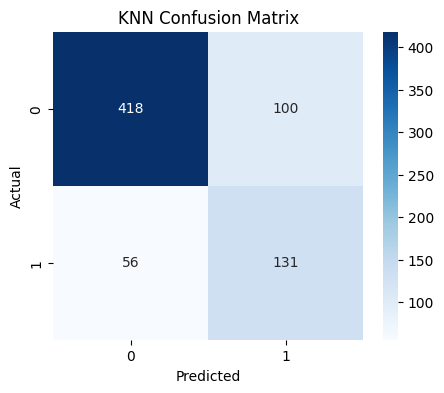

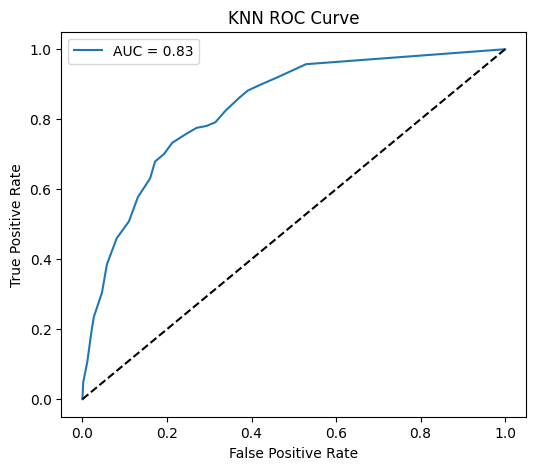

In [15]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
    print(f'Trial {trial.number}: n_neighbors={n_neighbors}, weights={weights}, p={p}, f1={score:.4f}')
    return score

study_knn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_knn.optimize(objective_knn, n_trials=50)

print('\n=== KNN Best Hyperparameters ===')
print(f'Best trial: {study_knn.best_trial.number}')
print(f'Best F1 score: {study_knn.best_value:.4f}')
print(f'Best params: {study_knn.best_params}')

best_params_knn = study_knn.best_params
best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(X_train_proc, y_train)
y_test_pred_knn = best_knn.predict(X_test_proc)
# KNN does not have predict_proba for binary classification with non-probabilistic outputs, so use decision_function or fallback
try:
    y_test_proba_knn = best_knn.predict_proba(X_test_proc)[:, 1]
except AttributeError:
    y_test_proba_knn = (y_test_pred_knn == 'Yes').astype(int)

print('KNN Test Metrics:')
print_metrics(y_test, y_test_pred_knn, pos_label='Yes')

cm = confusion_matrix(y_test, y_test_pred_knn)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test, y_test_proba_knn, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_knn)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend()
plt.show()